<a href="https://colab.research.google.com/github/harnalashok/timeseries/blob/main/prophet_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Forecasting at scale:
#  https://peerj.com/preprints/3190.pdf
#  https://github.com/facebook/prophet/tree/main/notebooks
# R manual:
#  https://cran.r-project.org/web/packages/prophet/prophet.pdf

In [1]:
# !  pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [26]:
data_url= 'https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv'
df = pd.read_csv(
                 data_url,
                 parse_dates=["ds"]
                )

In [27]:
df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [28]:
df.head()
df.shape   # (2905, 2)

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


(2905, 2)

In [29]:
df1 = df.copy()
df1.index = df1.ds

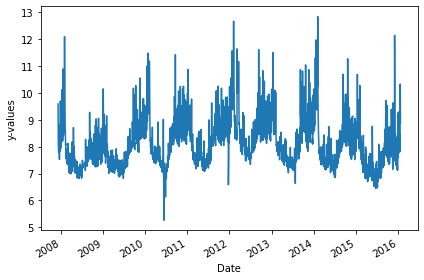

In [30]:
fig, ax = plt.subplots() ;
ax.plot(df1['y']) ;
ax.set_xlabel('Date') ;
ax.set_ylabel('y-values') ;
# Date ticklabels often overlap, so it is useful to 
#  rotate them and right align them
fig.autofmt_xdate() ; 
plt.tight_layout() ; # Adjust the padding between and around subplots.

We fit the model by instantiating a new Prophet object. Any settings to the forecasting procedure are passed into the constructor. Then you call its fit method and pass in the historical dataframe. Fitting should take 1-5 seconds.<br>
The Prophet fit () object takes arguments to configure the type of model you want, such as the type of growth, the type of seasonality, and more. By default, the model will work hard to figure out almost everything automatically.

The fit() function takes a DataFrame of time series data. The DataFrame must have a specific format. The first column must have the name ‘ds‘ and contain the date-times. The second column must have the name ‘y‘ and contain the observations. It also requires that the first column be converted to date-time objects, 

In [40]:
m = Prophet()

In [44]:
help(Prophet.fit)

Help on function fit in module prophet.forecaster:

fit(self, df, **kwargs)
    Fit the Prophet model.
    
    This sets self.params to contain the fitted model parameters. It is a
    dictionary parameter names as keys and the following items:
        k (Mx1 array): M posterior samples of the initial slope.
        m (Mx1 array): The initial intercept.
        delta (MxN array): The slope change at each of N changepoints.
        beta (MxK matrix): Coefficients for K seasonality features.
        sigma_obs (Mx1 array): Noise level.
    Note that M=1 if MAP estimation.
    
    Parameters
    ----------
    df: pd.DataFrame containing the history. Must have columns ds (date
        type) and y, the time series. If self.growth is 'logistic', then
        df must also have a column cap that specifies the capacity at
        each ds.
    kwargs: Additional arguments passed to the optimizing or sampling
        functions in Stan.
    
    Returns
    -------
    The fitted Prophet object.

In [33]:

m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzv_tfp01/iro2ht77.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzv_tfp01/c80cmmr6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22883', 'data', 'file=/tmp/tmpzv_tfp01/iro2ht77.json', 'init=/tmp/tmpzv_tfp01/c80cmmr6.json', 'output', 'file=/tmp/tmpzv_tfp01/prophet_modelttgll51x/prophet_model-20230221075654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method `Prophet.make_future_dataframe`. By default it will also include the dates from the history, so we will see the model fit as well.

In [45]:
help(Prophet.make_future_dataframe)

Help on function make_future_dataframe in module prophet.forecaster:

make_future_dataframe(self, periods, freq='D', include_history=True)
    Simulate the trend using the extrapolated generative model.
    
    Parameters
    ----------
    periods: Int number of periods to forecast forward.
    freq: Any valid frequency for pd.date_range, such as 'D' or 'M'.
    include_history: Boolean to include the historical dates in the data
        frame for predictions.
    
    Returns
    -------
    pd.Dataframe that extends forward from the end of self.history for the
    requested number of periods.



In [34]:
# Python
future = m.make_future_dataframe(periods=365)


,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


,ds,y
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


In [ ]:
future.tail(20)
df.tail(20)

A forecast is made by calling the predict() function and passing a DataFrame that contains one column named ‘ds‘ and rows with date-times for all the intervals to be predicted.

In [46]:
help(Prophet.predict)

Help on function predict in module prophet.forecaster:

predict(self, df: pandas.core.frame.DataFrame = None, vectorized: bool = True) -> pandas.core.frame.DataFrame
    Predict using the prophet model.
    
    Parameters
    ----------
    df: pd.DataFrame with dates for predictions (column ds), and capacity
        (column cap) if logistic growth. If not provided, predictions are
        made on the history.
    vectorized: Whether to use a vectorized method to compute uncertainty intervals. Suggest using
        True (the default) for much faster runtimes in most cases,
        except when (growth = 'logistic' and mcmc_samples > 0).
    
    Returns
    -------
    A pd.DataFrame with the forecast components.



In [35]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.203190,7.502944,8.905352
3266,2017-01-16,8.528195,7.861917,9.294679
3267,2017-01-17,8.315591,7.626712,9.001956
3268,2017-01-18,8.148199,7.397193,8.936257
3269,2017-01-19,8.160106,7.450896,8.874796


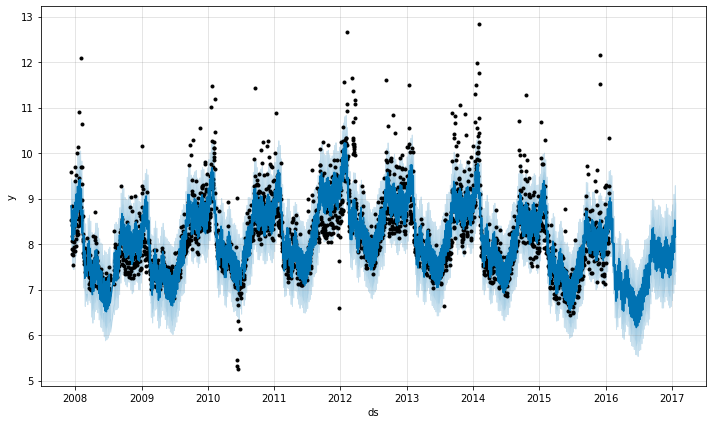

In [37]:
fig1 = m.plot(forecast)

If you want to see the forecast components, you can use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

In [47]:
help(Prophet.plot_components)

Help on function plot_components in module prophet.forecaster:

plot_components(self, fcst, uncertainty=True, plot_cap=True, weekly_start=0, yearly_start=0, figsize=None)
    Plot the Prophet forecast components.
    
    Will plot whichever are available of: trend, holidays, weekly
    seasonality, and yearly seasonality.
    
    Parameters
    ----------
    fcst: pd.DataFrame output of self.predict.
    uncertainty: Optional boolean to plot uncertainty intervals.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    weekly_start: Optional int specifying the start day of the weekly
        seasonality plot. 0 (default) starts the week on Sunday. 1 shifts
        by 1 day to Monday, and so on.
    yearly_start: Optional int specifying the start day of the yearly
        seasonality plot. 0 (default) starts the year on Jan 1. 1 shifts
        by 1 day to Jan 2, and so on.
    figsize: Optional tuple width, height in inches.


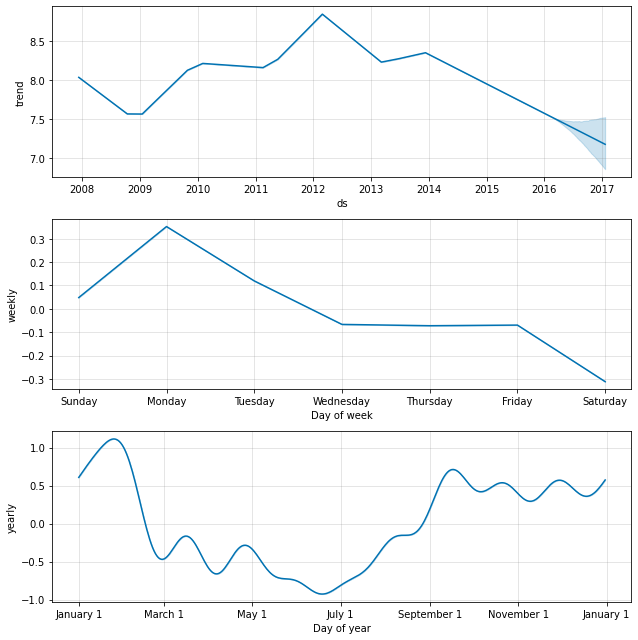

In [38]:
fig2 = m.plot_components(forecast)

An interactive figure of the forecast and components can be created with plotly. You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. You will also need to install the notebook and ipywidgets packages.

In [39]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)

More details about the options available for each method are available in the docstrings, for example, via help(Prophet) or help(Prophet.fit).